In [1]:
%matplotlib inline

from shared_content import *

In [29]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'MCS_JINST/Figures/'

First the range-based bias and resolution figures from MCBNBMCTrack

In [3]:
filedir = 'anafiles/'
#'SingleMuonRecoTrack'
#'MCBNBSelectedRecoTrack'
#'DataBNBSelectedRecoTrack'
#'MCBNBRecoTrack'
#'SingleMuonMCTrack'
anatype = 'MCBNBMCTrack' 

seglen = 10
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )


In [4]:
df, segdf = get_dfs(filedir + myfile)

In [5]:
#reco-true/true
def fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax)
            t =plt.title(titlestring,fontsize=16)
            #move the title up a bit
            #t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gaus Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
            plt.ylabel('Counts',fontsize=16)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
     
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT    
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label='Mean of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{N}$')
    plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=15)
    t = plt.title('Range-Based Fractional Bias',fontsize=20)
    #t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label='Width of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{2N}$')
    plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    t = plt.title('Range-Based Momentum Resolution',fontsize=20)
    plt.legend(loc='best',fontsize=15)
    #move the title up a bit
    #t.set_y(1.05) 
                    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)

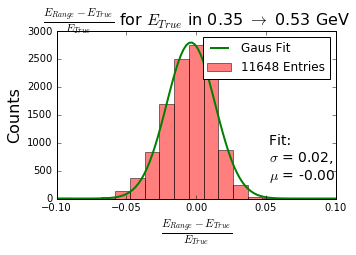

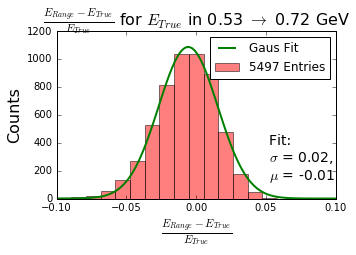

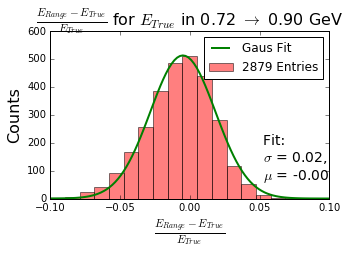

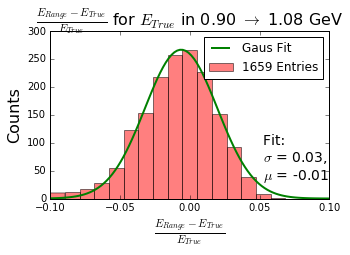

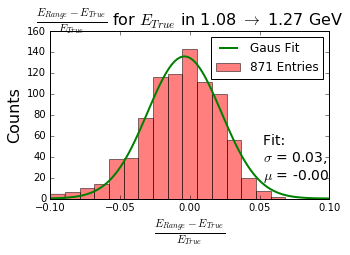

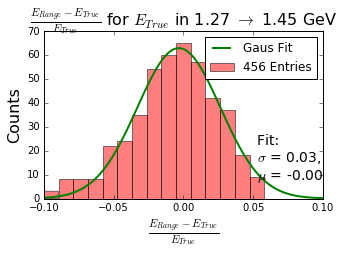

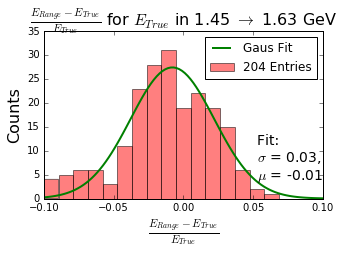

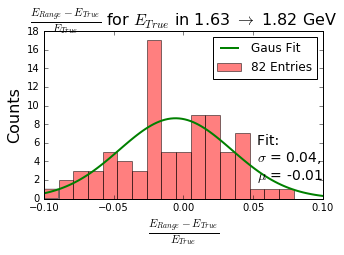

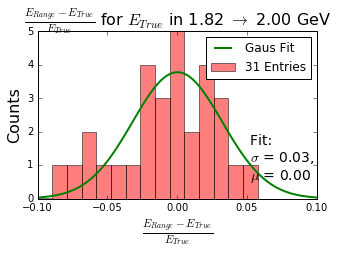

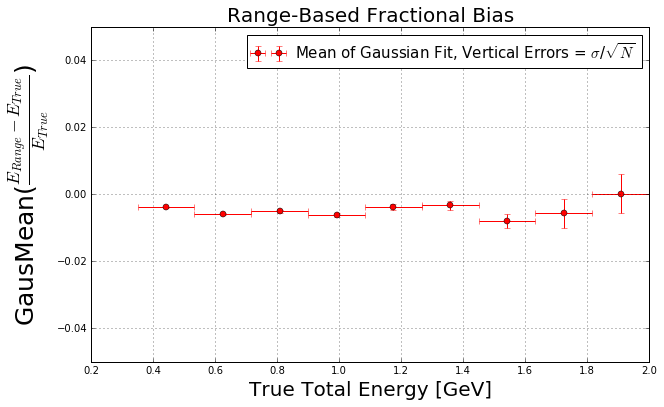

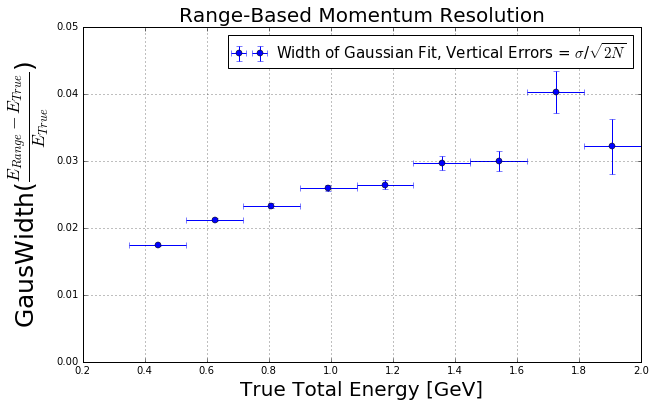

In [6]:
# Fractional bias plot for True vs Range energy for single MCTrack section only
if anatype == 'MCBNBMCTrack':
    fractional_bias_resolution_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'true_E',
                       slicetitlebase = 'true_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.1,0.1,20),
                       biasplotname = 'true_range_bias_%s.png'%anatype,
                       resplotname = 'true_range_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.05,.05),
                       resmainfig_ylims = (0,.05),
                       usegausfit = True)

Now we have the basic comparison fig for the good scan sample in data

In [7]:
anatype = 'DataBNBSelectedRecoTrack' 
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )

df, segdf = get_dfs(filedir + myfile)

#Read in handscan info if working with data
if anatype == 'DataBNBSelectedRecoTrack':
    filedir = 'handscan_results/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    df = df.merge(hsdf, on=['run','subrun','eventid'])

    segdf = segdf.merge(hsdf, on=['run','subrun','eventid'])

total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [8]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None, nbins=50):
    plt.figure(figsize=(10,6)) 
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = df.query(myquery)[xvar].values
    myy = df.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,nbins),np.linspace(0,2,nbins))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=20)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=20)
    blha = plt.title('%s'%titles[anatype],fontsize=18)
    #blha.set_y(1.04)
    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.55, plt.ylim()[1]*0.1, addtext, fontsize=20)
        
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname,dpi=600)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"

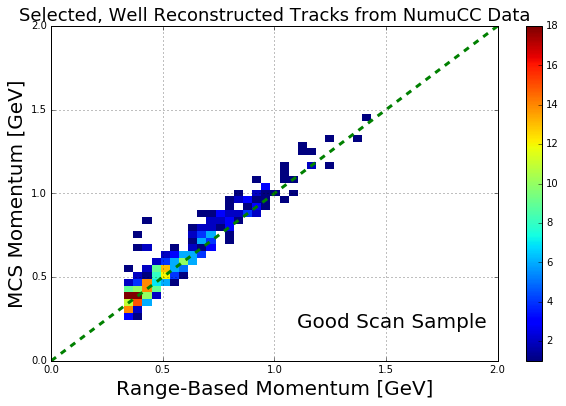

In [9]:
#Breakdown of events that were handscanned as good, and those handscanned as bad
if anatype == 'DataBNBSelectedRecoTrack':

    extraquery = 'not maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_goodhandscan.png',
                            extraquery = extraquery,
                        addtext = 'Good Scan Sample')

Now the highland validation plot for the data handscanned sample

In [10]:
def deflection_plot(binmin,binmax,nbins,extraquery=None,plotname=None, addtext=None, figname = None, customtitle = None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    print myquery
    mybins = np.linspace(binmin,binmax,nbins)
    
    myvar1 = 'dthetayoverpredictedRMS_fromMCS'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS'

    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)

    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/\\sigma_o^{HL}$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.2f' % result.params['wid'],\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=20)
   
    if customtitle is not None:
        plt.title(customtitle,fontsize=20)
        
    plt.xlabel('$\Delta\\theta_j$ / $\sigma_{(o,j)}^{HL}$',fontsize=25)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2,fontsize=16)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.25, plt.ylim()[1]*0.85, addtext, fontsize=20)
        
    if write_figures:
        fullfigname = figdir + 'Highland_validation_%s.png' % anatype
        if figname is not None:
            fullfigname = figdir + figname
            
        print "\n\n WRITING FIGURE %s! \n\n"%fullfigname
        plt.tight_layout()
        if plotname is not None: plt.savefig(figdir + plotname,dpi=600)
        else: plt.savefig(fullfigname,dpi=600)

run < 99999999 and not maybe_bad
Parameters([('amp', <Parameter 'amp', value=0.95703734426515708 +/- 0.0146, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.0061563024413791483 +/- 0.0166, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.93988957525922634 +/- 0.0166, bounds=[-inf:inf]>)])


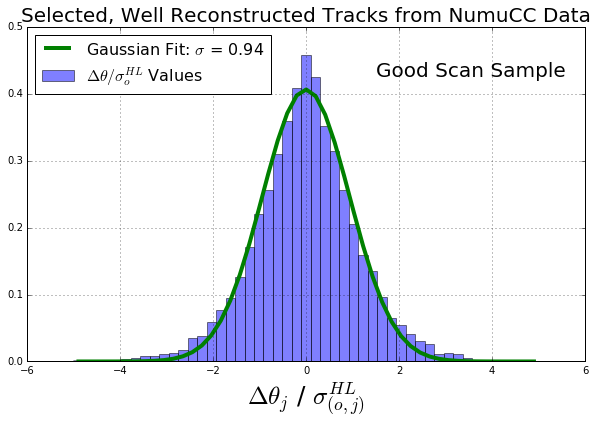

In [11]:
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    dummy = deflection_plot(-5,5,50,extraquery=myextraquery,addtext='Good Scan Sample',\
                            figname = 'Highland_validation_DataBNBSelectedRecoTrack_goodscan.png')

Now the fractional bias/resolution overlay plots for simulation and data

In [12]:
anatypes = ['MCBNBSelectedRecoTrack','DataBNBSelectedRecoTrack']
filedir = 'anafiles/'

df_dict = {}

for anatype in anatypes:
    
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
    df_dict[anatype], dummy = get_dfs(filedir+myfile)
    
#Read in handscan info if working with data
filedir = 'handscan_results/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

df_dict['DataBNBSelectedRecoTrack'] = df_dict['DataBNBSelectedRecoTrack']\
                                        .merge(hsdf, on=['run','subrun','eventid'])


total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [26]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',markersize=10,label='%s'%titles[anatype])
    plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Bias for Various Input Samples',fontsize=20)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)

In [27]:
#reco-true/true
def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',markersize=10,label='%s'%titles[anatype])
    plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Momentum Resolution for Various Input Samples',fontsize=20)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)

 

 Writing the main bias figure!! MCS_JINST/Figures/MCS_range_bias_multiplesamples_publicplot.png


 

 Writing the main res figure!! MCS_JINST/Figures/MCS_range_resolution_multiplesamples_publicplot.png




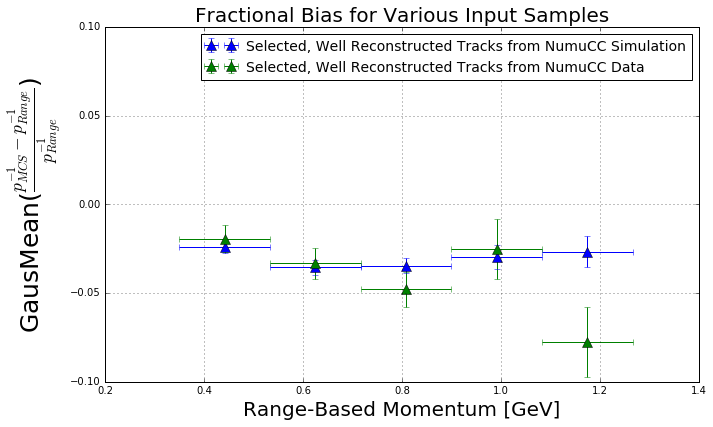

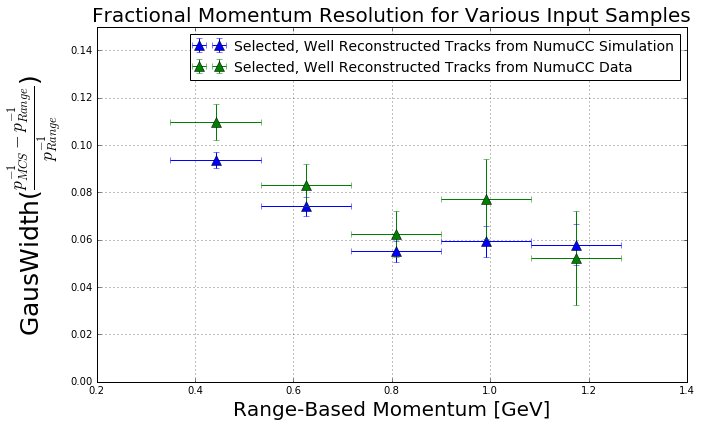

In [30]:

fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_multiplesamples_publicplot.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_multiplesamples_publicplot.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)